# Acheiving 99.4% accuracy in a resource constrained system

## Constraints:
- Parameters should be less than 20,000
- Accuracy to be achieved in less than 20 epochs
- Fully connected layers must no be used

## How did we achieve it
- We started with a plain network with a minimal network that achieved 98.84% accuracy
- After adding 1x1 convolution just before max pooling, the accuracy increased to 99.09%
- Adding batch normalization after every concolution, increased the accuracy to 99.37%
- All the above network had parameters ~12.5k
- After a bit of experimentation, increasing the parameters to ~17.5k did the trick and achieved 99.42% max accuracy

### Setup Google Drive for saving / reloading previous saved values

In [9]:
from google.colab import drive
drive.mount("/content/drive")

base_folder = 'drive/My Drive/eva_stored_from_colab/eva5/'
acc_recorder_file = "highest_accuracy_achieved"
model_file_name = "final_model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import required modules

In [10]:
from __future__ import print_function
from operator import itemgetter
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### The Network Architecture

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.antman = nn.Conv2d(8, 8, 1)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 16, 3)
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 10, 3)
        self.bn6 = nn.BatchNorm2d(10)
        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.antman(self.pool1(x))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.gap(self.bn6(self.conv6(x)))
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

### Calculating total parameters

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3            [-1, 8, 24, 24]             584
       BatchNorm2d-4            [-1, 8, 24, 24]              16
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]              72
            Conv2d-7           [-1, 16, 10, 10]           1,168
       BatchNorm2d-8           [-1, 16, 10, 10]              32
            Conv2d-9             [-1, 16, 8, 8]           2,320
      BatchNorm2d-10             [-1, 16, 8, 8]              32
           Conv2d-11             [-1, 16, 6, 6]           2,320
      BatchNorm2d-12             [-1, 16, 6, 6]              32
           Conv2d-13             [-1, 10, 4, 4]           1,450
      BatchNorm2d-14             [-1, 1

### Downloading the MNIST dataset

In [13]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw





Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Defining train & test functions

In [14]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    
    total_imgs = len(train_loader.dataset)
    train_loss /= total_imgs
    accuracy = 100. * correct / total_imgs

    print('\nTrain Data: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        train_loss, correct, total_imgs, accuracy)
    )
    
    return train_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

def record_max_acc(max_acc):
    f = open(base_folder+acc_recorder_file, "w")
    f.write(str(max_acc))
    f.close()

### Training for 20 epochs

In [15]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start = time.time()
test_acc = []
train_acc = []

try:
    with open(base_folder+acc_recorder_file, "r") as infl:
        max_acc = float(infl.read().strip())
except:
    max_acc = 0.0

print("\nLAST RECORDED MAX ACCURACY: ", max_acc)
for epoch in range(1, 21):
    ep_start = time.time()
    print()
    print("EPOCH NUM {}".format(epoch))
    trl, tra = train(model, device, train_loader, optimizer, epoch)
    tsl, tsa = test(model, device, test_loader)
    test_acc.append(tsa)
    train_acc.append(tra)
    if tsa > max_acc:
        max_acc = tsa
        torch.save(model.state_dict(), base_folder+model_file_name+"_sd.pth")
        record_max_acc(max_acc)
    print("-----------------------------------------------")
print("TOTAL TRAINING TIME: ", time.time() - start)
print("LAST 10 EPOCH AVG ACC: ", sum(test_acc[-10:]) / len(test_acc[-10:]) )
print("LAST 5 EPOCH AVG ACC: ", sum(test_acc[-5:]) / len(test_acc[-5:]) )
print("MAX ACCURACY: ", max(test_acc))

  0%|          | 0/469 [00:00<?, ?it/s]


LAST RECORDED MAX ACCURACY:  0.9942

EPOCH NUM 1


loss=0.08069618791341782 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]


Train Data: Average loss: 0.0026, Accuracy: 56645/60000 (94.4083%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 9822/10000 (98.2200%)

-----------------------------------------------

EPOCH NUM 2


loss=0.061845943331718445 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]


Train Data: Average loss: 0.0007, Accuracy: 58999/60000 (98.3317%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9877/10000 (98.7700%)

-----------------------------------------------

EPOCH NUM 3


loss=0.13577617704868317 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]


Train Data: Average loss: 0.0005, Accuracy: 59207/60000 (98.6783%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9877/10000 (98.7700%)

-----------------------------------------------

EPOCH NUM 4


loss=0.05048802122473717 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]


Train Data: Average loss: 0.0004, Accuracy: 59313/60000 (98.8550%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9901/10000 (99.0100%)

-----------------------------------------------

EPOCH NUM 5


loss=0.019607122987508774 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Train Data: Average loss: 0.0003, Accuracy: 59429/60000 (99.0483%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9906/10000 (99.0600%)

-----------------------------------------------

EPOCH NUM 6


loss=0.05354414880275726 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Train Data: Average loss: 0.0003, Accuracy: 59448/60000 (99.0800%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9914/10000 (99.1400%)

-----------------------------------------------

EPOCH NUM 7


loss=0.039321910589933395 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Train Data: Average loss: 0.0003, Accuracy: 59527/60000 (99.2117%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9921/10000 (99.2100%)

-----------------------------------------------

EPOCH NUM 8


loss=0.03354855254292488 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Train Data: Average loss: 0.0003, Accuracy: 59515/60000 (99.1917%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9934/10000 (99.3400%)

-----------------------------------------------

EPOCH NUM 9


loss=0.019565260037779808 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Train Data: Average loss: 0.0002, Accuracy: 59614/60000 (99.3567%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9919/10000 (99.1900%)

-----------------------------------------------

EPOCH NUM 10


loss=0.02374468743801117 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Train Data: Average loss: 0.0002, Accuracy: 59587/60000 (99.3117%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9927/10000 (99.2700%)

-----------------------------------------------

EPOCH NUM 11


loss=0.008685625158250332 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Train Data: Average loss: 0.0002, Accuracy: 59611/60000 (99.3517%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.1100%)

-----------------------------------------------

EPOCH NUM 12


loss=0.04035186767578125 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]


Train Data: Average loss: 0.0002, Accuracy: 59648/60000 (99.4133%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9915/10000 (99.1500%)

-----------------------------------------------

EPOCH NUM 13


loss=0.07659898698329926 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Train Data: Average loss: 0.0002, Accuracy: 59628/60000 (99.3800%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9930/10000 (99.3000%)

-----------------------------------------------

EPOCH NUM 14


loss=0.011430171318352222 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]


Train Data: Average loss: 0.0002, Accuracy: 59683/60000 (99.4717%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9925/10000 (99.2500%)

-----------------------------------------------

EPOCH NUM 15


loss=0.006174769252538681 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Train Data: Average loss: 0.0002, Accuracy: 59654/60000 (99.4233%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9924/10000 (99.2400%)

-----------------------------------------------

EPOCH NUM 16


loss=0.07449482381343842 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Train Data: Average loss: 0.0002, Accuracy: 59712/60000 (99.5200%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9931/10000 (99.3100%)

-----------------------------------------------

EPOCH NUM 17


loss=0.03353279083967209 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Train Data: Average loss: 0.0002, Accuracy: 59713/60000 (99.5217%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9931/10000 (99.3100%)

-----------------------------------------------

EPOCH NUM 18


loss=0.05650612339377403 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Train Data: Average loss: 0.0001, Accuracy: 59721/60000 (99.5350%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9935/10000 (99.3500%)

-----------------------------------------------

EPOCH NUM 19


loss=0.020223861560225487 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]


Train Data: Average loss: 0.0001, Accuracy: 59741/60000 (99.5683%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9932/10000 (99.3200%)

-----------------------------------------------

EPOCH NUM 20


loss=0.009075390174984932 batch_id=468: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]


Train Data: Average loss: 0.0001, Accuracy: 59707/60000 (99.5117%)




Test set: Average loss: 0.0279, Accuracy: 9925/10000 (99.2500%)

-----------------------------------------------
TOTAL TRAINING TIME:  503.519412279129
LAST 10 EPOCH AVG ACC:  0.9925900000000001
LAST 5 EPOCH AVG ACC:  0.99308
MAX ACCURACY:  0.9935


### Chart - Train vs Test accuracy for each epoch

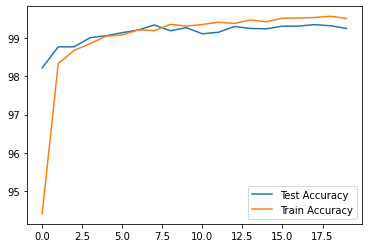

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis = list(range(len(test_acc)))
new_test_acc = [x*100.0 for x in test_acc]

plt.plot(xaxis, new_test_acc, label="Test Accuracy")
plt.plot(xaxis, train_acc, label="Train Accuracy")
plt.legend()
plt.show()